# Question: What is the difference between the correlation of temperature and humidity in the summer and winter between the north and the south?

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (25, 20)  # in inches

In [2]:
north_data_in = pd.read_csv("data_north.csv")
south_data_in = pd.read_csv("data_south.csv")

In [ ]:
new_column_names = ["station", "date", "temperature", "humidity"]

# Update column names
north_data_in.columns = new_column_names
south_data_in.columns = new_column_names

# Step 1: Drop NaNs
north_data_clean = north_data_in.dropna()
south_data_clean = south_data_in.dropna()

# Step 2: Count how many stations per date in each df
north_data_station_counts = north_data_clean.groupby("date")["station"].nunique()
south_data_station_counts = south_data_clean.groupby("date")["station"].nunique()

# Step 3: Keep only dates where all stations are present
num_stations = north_data_in["station"].nunique()  # same for both
valid_dates_north_data = north_data_station_counts[north_data_station_counts == num_stations].index
valid_dates_south_data = south_data_station_counts[south_data_station_counts == num_stations].index

# Step 4: Find common dates with full data in both dfs
common_full_dates = valid_dates_north_data.intersection(valid_dates_south_data)

# Step 5: Filter both dfs to only common, fully-covered dates
north_data = north_data_clean[north_data_clean["date"].isin(common_full_dates)].copy()
south_data = south_data_clean[south_data_clean["date"].isin(common_full_dates)].copy()

# Step 6: Reset row indices
north_data = north_data.reset_index(drop=True)
south_data = south_data.reset_index(drop=True)

# Step 7: Convert string dates to pandas.Timestamp dates
north_data["date"] = pd.to_datetime(north_data["date"], format="%d-%m-%Y %H:%M")
south_data["date"] = pd.to_datetime(south_data["date"], format="%d-%m-%Y %H:%M")

# Allows us to verify the data is fine
print("North Data")
display(north_data.head(9))
print("\nSouth Data")
display(south_data.head(9))

North Data


,station,date,temperature,humidity
0,כפר גלעדי 10/2007-07/2025,2020-10-22 06:00:00,19.0,90.0
1,מרום גולן פיכמן 01/1998-07/2025,2020-10-22 06:00:00,6.1,94.0
2,כפר בלום 07/2005-07/2025,2020-10-22 06:00:00,15.4,87.0
3,כפר גלעדי 10/2007-07/2025,2020-10-22 09:00:00,22.5,51.0
4,מרום גולן פיכמן 01/1998-07/2025,2020-10-22 09:00:00,20.2,51.0
5,כפר בלום 07/2005-07/2025,2020-10-22 09:00:00,21.0,68.0
6,כפר גלעדי 10/2007-07/2025,2020-10-22 12:00:00,29.6,36.0
7,מרום גולן פיכמן 01/1998-07/2025,2020-10-22 12:00:00,27.2,24.0
8,כפר בלום 07/2005-07/2025,2020-10-22 12:00:00,30.6,31.0



South Data


,station,date,temperature,humidity
0,אשלים 02/2016-07/2025,2020-10-22 06:00:00,16.6,96.0
1,שדה בוקר 01/2004-07/2025,2020-10-22 06:00:00,15.9,92.0
2,עבדת 10/2008-07/2025,2020-10-22 06:00:00,17.3,95.0
3,אשלים 02/2016-07/2025,2020-10-22 09:00:00,21.9,81.0
4,שדה בוקר 01/2004-07/2025,2020-10-22 09:00:00,22.5,73.0
5,עבדת 10/2008-07/2025,2020-10-22 09:00:00,21.0,80.0
6,אשלים 02/2016-07/2025,2020-10-22 12:00:00,28.5,51.0
7,שדה בוקר 01/2004-07/2025,2020-10-22 12:00:00,27.8,49.0
8,עבדת 10/2008-07/2025,2020-10-22 12:00:00,27.3,46.0


### Since there are 3 stations in each dataframe, we will examine the average of the recordings of the 3 stations for each date.

In [45]:
# Average the values and sort by date
north_avg = north_data.groupby("date")[["temperature", "humidity"]].mean().reset_index().sort_values(by="date")
south_avg = south_data.groupby("date")[["temperature", "humidity"]].mean().reset_index().sort_values(by="date")

# Display a sample of the values
print("Averaged North Data")
display(north_avg.head(3))
print("\nAveraged South Data")
display(south_avg.head(3))

Averaged North Data


,date,temperature,humidity
0,2020-10-22 06:00:00,13.500000,90.333333
1,2020-10-22 09:00:00,21.233333,56.666667
2,2020-10-22 12:00:00,29.133333,30.333333



Averaged South Data


,date,temperature,humidity
0,2020-10-22 06:00:00,16.600000,94.333333
1,2020-10-22 09:00:00,21.800000,78.000000
2,2020-10-22 12:00:00,27.866667,48.666667


### Comparing between winter and summer will be useful. <br>For our purposes, Summer is May through October and Winter is November through April (both inclusive).

In [38]:
# This helps see which measurements are in summer and which are in winter.
# Colors the background of the plot yellow and blue according to whether the season is currently winter or summer
def add_seasonal_background(ax, start_date, end_date):
    current_date = start_date
    
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        
        if 5 <= month <= 10:  # Summer (May-October)
            # Find the end of this summer period
            season_end = min(pd.Timestamp(year, 10, 31), end_date)
            ax.axvspan(current_date, season_end, alpha=0.25, color='yellow', zorder=0)
            current_date = season_end + pd.Timedelta(days=1)
            
        else:  # Winter (November-April)
            if month >= 11:  # November-December
                season_end = min(pd.Timestamp(year, 12, 31), end_date)
            else:  # January-April
                season_end = min(pd.Timestamp(year, 4, 30), end_date)
            
            ax.axvspan(current_date, season_end, alpha=0.25, color='lightblue', zorder=0)
            current_date = season_end + pd.Timedelta(days=1)

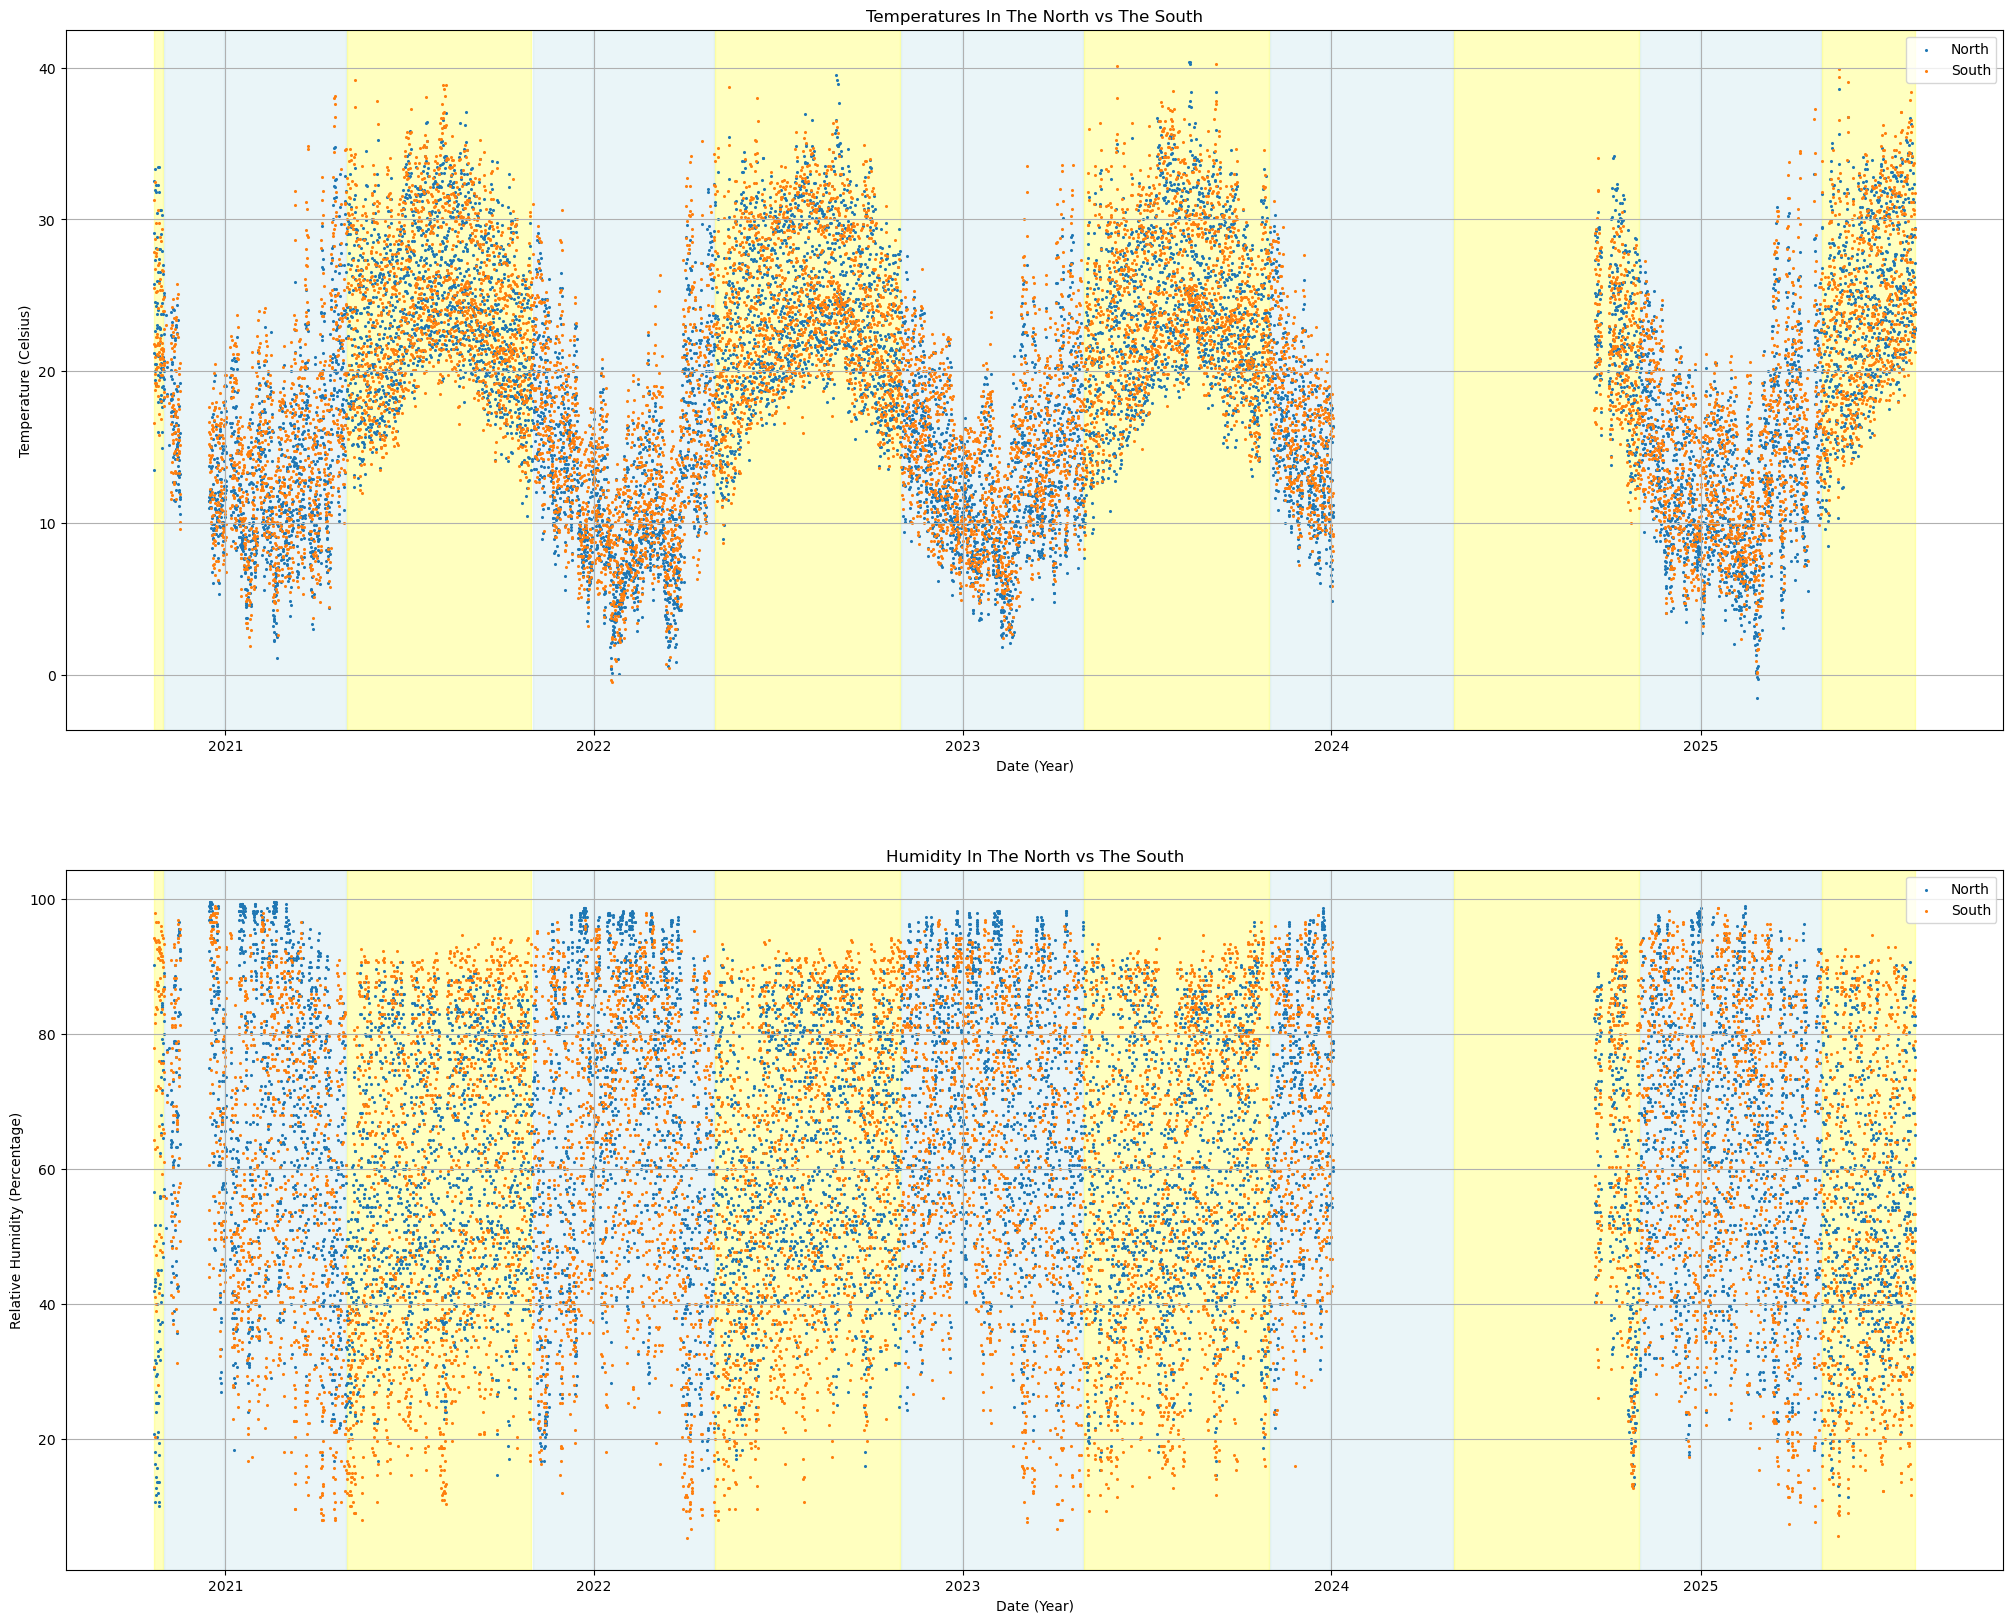

In [ ]:
# Seperate the data into easier-to-use arrays
dates = np.array(north_avg["date"])

north_temps = np.array(north_avg["temperature"])
south_temps = np.array(south_avg["temperature"])

north_humidities = np.array(north_avg["humidity"])
south_humidities = np.array(south_avg["humidity"])



# Create two subplots, one for the temperatures and one for the humidities
fig, ax = plt.subplots(nrows=2, ncols=1)
(temperature_ax, humidity_ax) = ax


# plot the temperatures as a function of the time
temperature_ax.scatter(dates, north_humidities, color="#1f77b4", alpha=1, s=1.5, label="North")

temperature_ax.scatter(dates, south_temps, color="#ff7f0e", alpha=1, s=1.5, label="South")

# color background according to season for better visual clarity
add_seasonal_background(temperature_ax, north_avg["date"][0], north_avg["date"][len(north_avg["date"])-1])

# set other graph details.
temperature_ax.legend(loc='upper right')
temperature_ax.grid()
temperature_ax.set_title("Temperatures In The North vs The South")
temperature_ax.set_xlabel("Date (Year)")
temperature_ax.set_ylabel("Temperature (Celsius)")



# plot the humidities as a function of the time
humidity_ax.scatter(dates, north_humidities, alpha=1, s=1.5, label="North")

humidity_ax.scatter(dates, south_humidities, alpha=1, s=1.5, label="South")

# color background according to season for better visual clarity
add_seasonal_background(humidity_ax, north_avg["date"][0], north_avg["date"][len(north_avg["date"])-1])

# set other graph details.
humidity_ax.legend(loc='upper right')
humidity_ax.grid()
humidity_ax.set_title("Humidity In The North vs The South")
humidity_ax.set_xlabel("Date (Year)")
humidity_ax.set_ylabel("Relative Humidity (Percentage)")


plt.show()

### We can see that regardless of the season and location, the temperature and the humidity are inversely related.

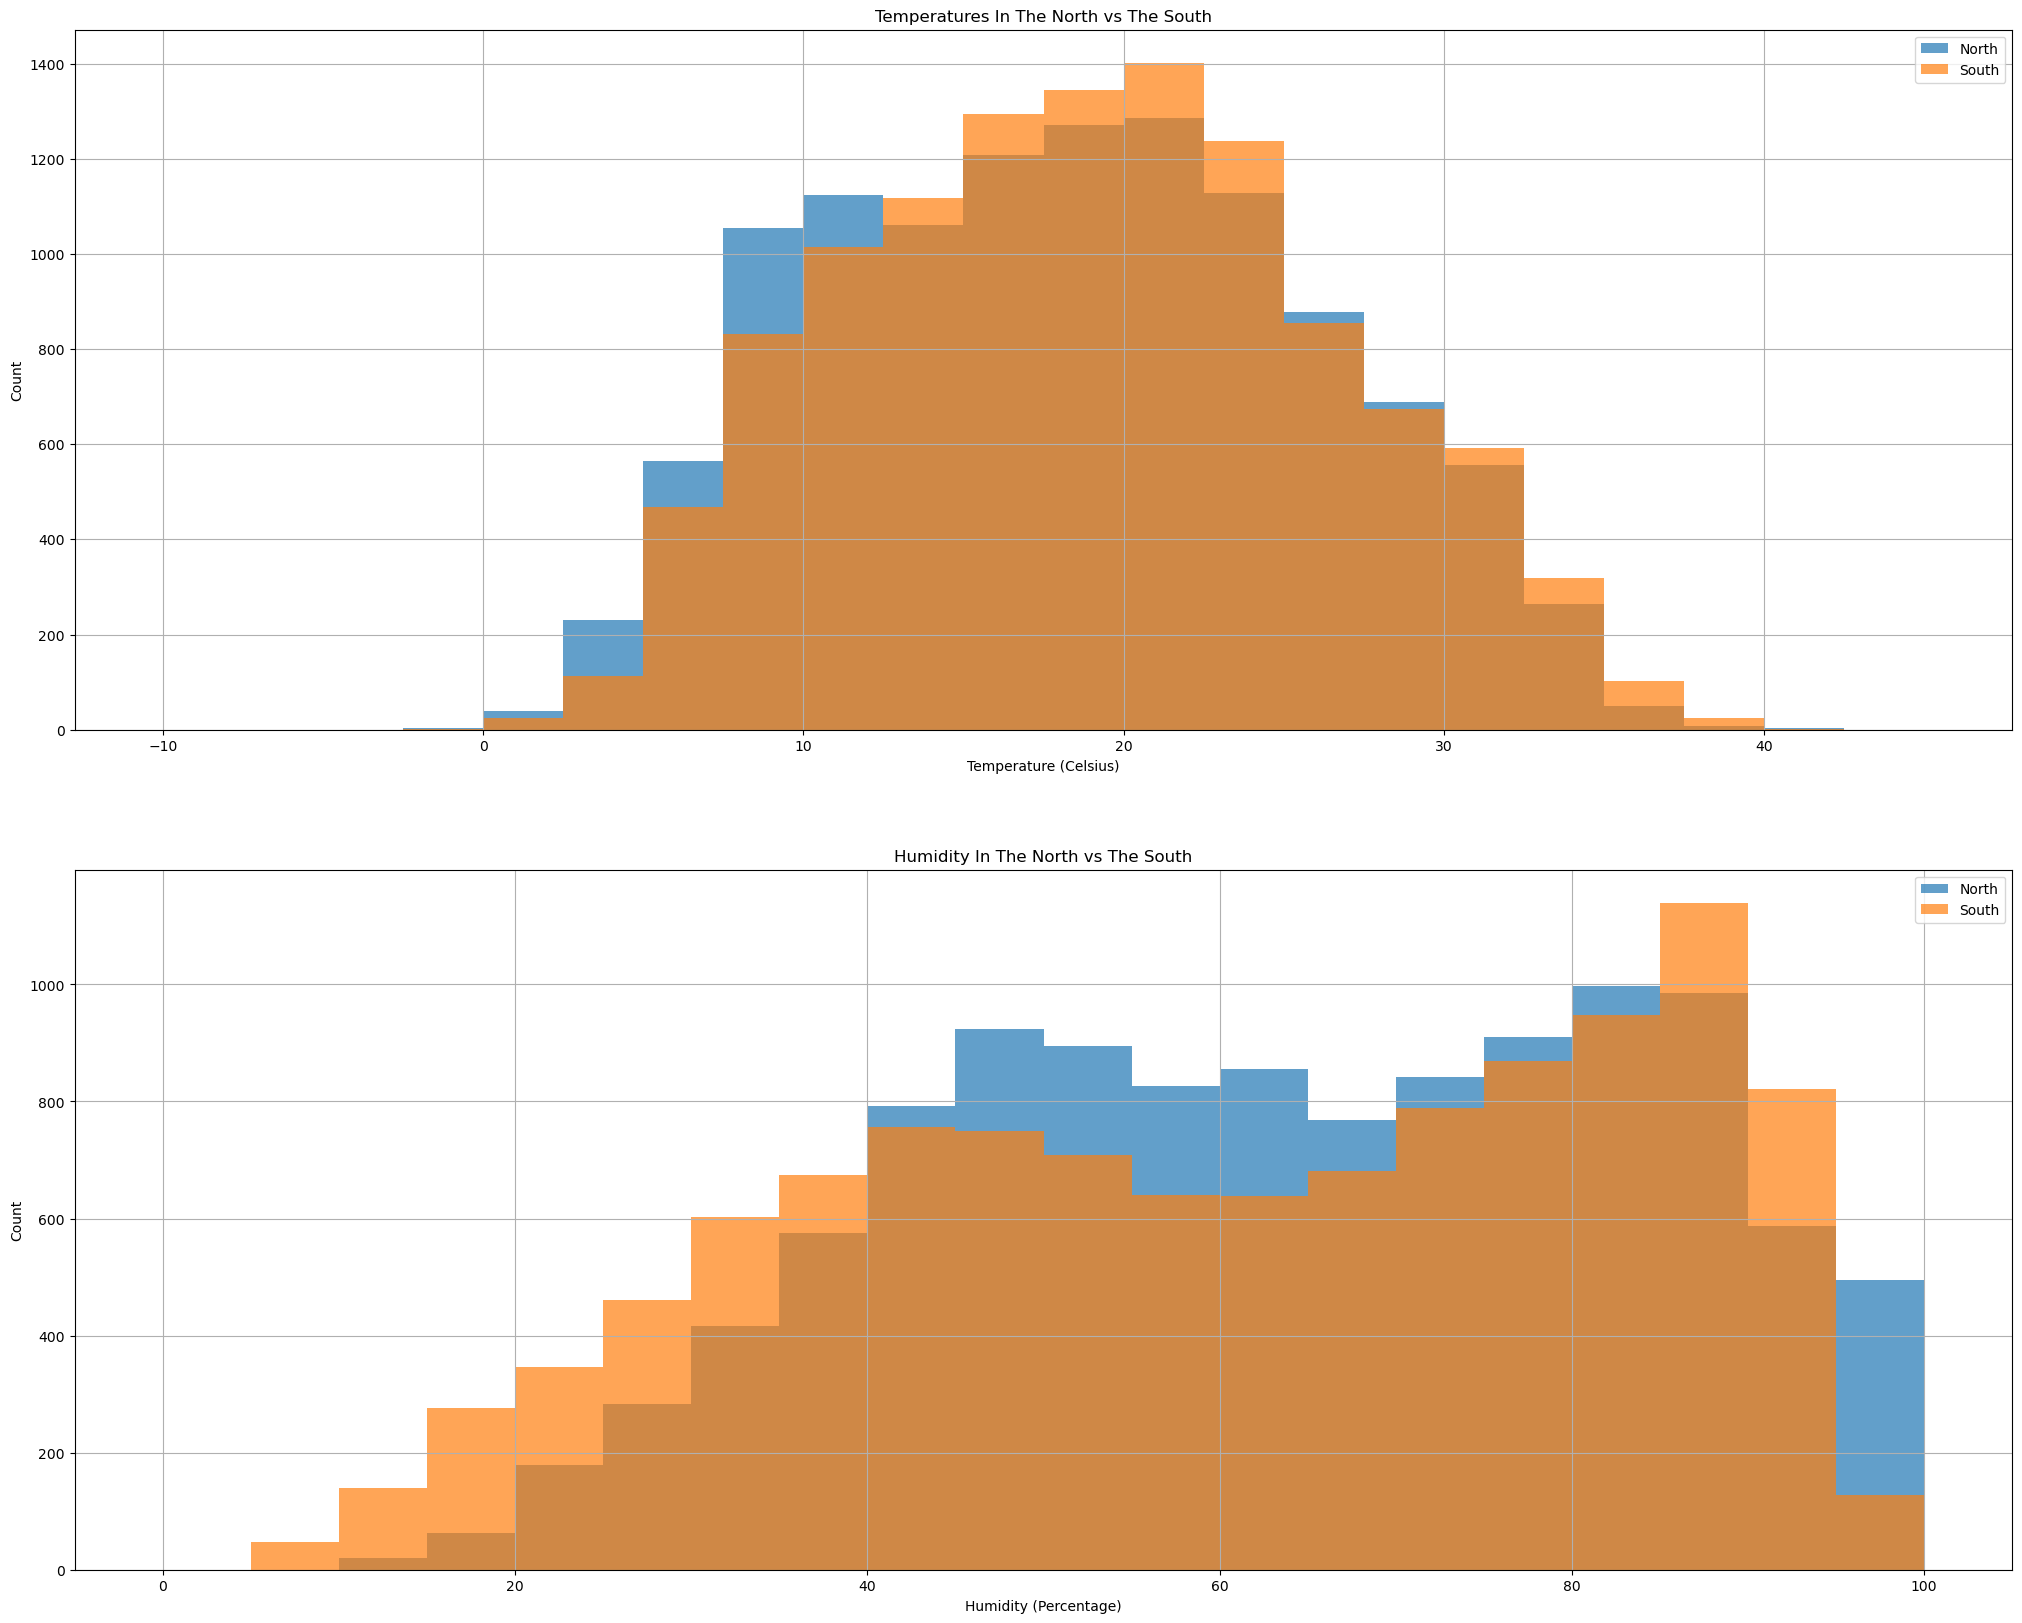

In [ ]:
# Create the 2 axes for the temperature and the humidity.
fig, ax = plt.subplots(nrows=2, ncols=1)
(temperature_ax, humidity_ax) = ax

# Finer control over the bins was needed, so here we specify exactly what bins we need.
temperature_bins = np.linspace(-10, 45, 22+1)
humidity_bins = np.linspace(0, 100, 20+1)


# plot the temperatures.
temperature_ax.hist(north_temps, color="#1f77b4", bins=temperature_bins, alpha=0.7, align='mid', label="North")

temperature_ax.hist(south_temps, color="#ff7f0e", bins=temperature_bins, alpha=0.7, align='mid', label="South")


# set other graph details.
temperature_ax.legend(loc='upper right')
temperature_ax.grid()
temperature_ax.set_title("Temperatures In The North vs The South")
temperature_ax.set_xlabel("Temperature (Celsius)")
temperature_ax.set_ylabel("Count")



# plot the humidities.
humidity_ax.hist(north_humidities, color="#1f77b4", bins=humidity_bins, alpha=0.7, align='mid', label="North")

humidity_ax.hist(south_humidities, color="#ff7f0e", bins=humidity_bins, alpha=0.7, align='mid', label="South")


# set other graph details.
humidity_ax.legend(loc='upper right')
humidity_ax.grid()
humidity_ax.set_title("Humidity In The North vs The South")
humidity_ax.set_xlabel("Humidity (Percentage)")
humidity_ax.set_ylabel("Count")

plt.show()


#### It is worth noting that the histogram of the humidity is bimodal in the south and in the north, but the histogram of the temperatures is bimodal in the north and unimodal in the south. 

In [ ]:
def mean(x):
    summed = 0
    for i in x:
        summed += i
    return summed/len(x)

def stdev(x):
    sum_squares = 0
    mean_val = mean(x)
    for i in x:
        sum_squares += (i - mean_val)**2
    
    return (sum_squares/(len(x)-1))**0.5

def cov(x_in, y_in):
    y = []
    x = []

    for i in range(min(len(x_in), len(y_in))):
        y.append(y_in[i])
        x.append(x_in[i])
    summed = 0
    mean_y = mean(y)
    mean_x = mean(x)
    
    for i in range(len(x)):
        summed += (x[i] - mean_x)*(y[i] - mean_y)
    
    return summed/(len(x)-1)

def corr(x_in, y_in):
    y = []
    x = []

    for i in range(min(len(x_in), len(y_in))):
        y.append(y_in[i])
        x.append(x_in[i])
    
    return cov(x, y)/(stdev(x)*stdev(y))



# Normalize all the data so the correlation is not skewed.
normalized_north_temps = (north_temps - np.min(north_temps)) / (np.max(north_temps) - np.min(north_temps))
normalized_south_temps = (south_temps - np.min(south_temps)) / (np.max(south_temps) - np.min(south_temps))

normalized_north_humidities = (north_humidities - np.min(north_humidities)) / (np.max(north_humidities) - np.min(north_humidities))
normalized_south_humidities = (south_humidities - np.min(south_humidities)) / (np.max(south_humidities) - np.min(south_humidities))



print(f"The correlation coefficient between the temperature and the humidity in the north: {corr(normalized_north_temps, normalized_north_humidities)}")
print(f"The correlation coefficient between the temperature and the humidity in the south: {corr(normalized_south_temps, normalized_south_humidities)}")

The correlation coefficient between the temperature and the humidity in the north: -0.6569191992046285
The correlation coefficient between the temperature and the humidity in the south: -0.6181780797669151
